In [ ]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install -U scikit-learn
!pip install ipympl
!pip install seaborn
!pip install pyarrow
!pip install scipy
!pip install polars

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import json
from scipy.stats import bootstrap
import scipy.stats as stats
import polars as pl
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.7f}'.format
np.random.seed(42)

In [2]:
def create_box_and_hist(data, column):
    fig, (ax_hist, ax_box) = plt.subplots(2, figsize=(4, 4), gridspec_kw={"height_ratios": (.85, .15)})
    ax_hist.hist(data[column], bins=20, color='skyblue', edgecolor='black')
    ax_hist.set_title('Histogram')
    ax_hist.set_xlabel(f'# {column}')
    ax_box.boxplot(data[column], vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='orange'))
    ax_box.set_xticks([])
    ax_box.set_yticks([])
    plt.tight_layout()
    plt.show()

def boot(data, column, stat, stat_label):
    rnd = 42
    res = bootstrap((data[column].values,), stat, confidence_level=0.9,
                    random_state=rnd, batch=1)
    fig, ax = plt.subplots()
    ax.hist(res.bootstrap_distribution, bins=25)
    ax.set_title('Bootstrap Distribution')
    ax.set_xlabel(stat_label)
    ax.set_ylabel('frequency')
    plt.show()
    return res

def histo(df):
    df.hist()
    plt.tight_layout()
    plt.show()

In [ ]:
features = ['products','helpful','funny', 'hours', 'recommended']

In [3]:
# dfreco = pd.read_csv("recommendations.csv")
# dfreco.to_parquet("recommendations.parquet")

In [4]:
dfreco = pd.read_parquet("recommendations.parquet").set_index('review_id')
#dfgame = pd.read_csv("games.csv")
#dfuser = pd.read_csv("users.csv")
#dfmeta = pd.read_json('games_metadata.json', lines=False)

In [6]:
df = dfreco.groupby('user_id').agg({'helpful':'sum', 'funny':'sum', 'app_id': 'nunique', 'is_recommended':'sum', 'hours':'sum'}).rename(columns={'app_id': 'products', 'is_recommended':'recommended'})
X = df[features].values

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)
pca_result = pca.fit_transform(X)

df['sort_col'] = pca_result[:,0]


In [8]:
std = df[features].std()
inverse_std = 1 / std
total_inverse_std = inverse_std.sum()
weights = inverse_std / total_inverse_std
print(weights)

products      0.4059023
helpful       0.0260522
funny         0.0564568
hours         0.0063831
recommended   0.5052056
dtype: float64


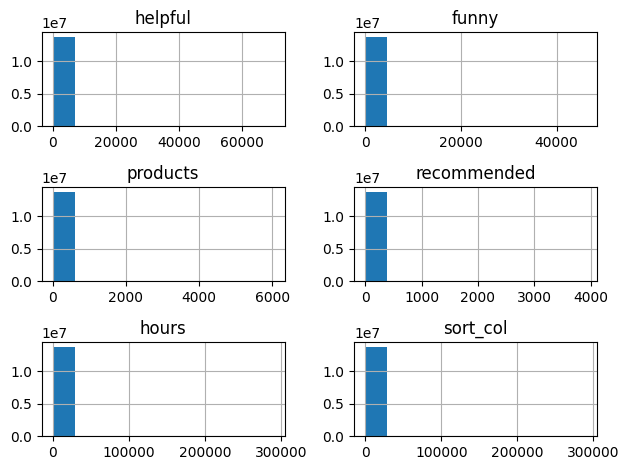

In [9]:
histo(df)
df = df[((df.helpful > 0)|(df.funny > 0))&(df.recommended > 0)]
df = df[df.recommended < df.products]
df['weighted_avg'] = df.products*0.4059023 + df.helpful*0.0260522 + df.funny*0.0564568 + df.hours*0.0063831 + df.recommended*0.5052056
df = df[df['sort_col'] >= np.percentile(df['sort_col'].values, 99)]

In [ ]:
#df.drop('weighted_avg', axis=1, inplace=True)

In [10]:
df.describe()

,helpful,funny,products,recommended,hours,sort_col,weighted_avg
count,"14,442.0000000","14,442.0000000","14,442.0000000","14,442.0000000","14,442.0000000","14,442.0000000","14,442.0000000"
mean,670.2482343,166.8196926,84.4579006,65.6105803,"6,512.0691455","6,239.6148421",135.8752243
std,"2,142.4276530",775.7556029,140.9870256,99.5026006,"4,652.3862424","4,664.8588971",169.1717157
min,0.0000000,0.0000000,6.0000000,1.0000000,"3,412.9000000","4,193.3821637",34.2259438
25%,49.0000000,7.0000000,31.0000000,24.0000000,"4,901.9000000","4,616.0920794",66.5534027
50%,161.0000000,28.0000000,52.0000000,41.0000000,"5,550.1000000","5,265.2680379",92.3129810
75%,490.0000000,106.0000000,91.0000000,73.0000000,"6,782.4750000","6,516.7178291",143.7846710
max,"70,096.0000000","46,186.0000000","6,045.0000000","3,920.0000000","290,694.2000000","290,676.3714859","5,031.1218076"


In [12]:
X = df[features].values
iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(X)
scores = iso.decision_function(X)

df["iso"] = outliers
df["iso_score"]  = scores
df['type'] = df['iso'].apply(lambda x: "Outlier" if x == -1 else "Inlier")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14442 entries, 814 to 14305521
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   helpful       14442 non-null  int64  
 1   funny         14442 non-null  int64  
 2   products      14442 non-null  int64  
 3   recommended   14442 non-null  int64  
 4   hours         14442 non-null  float64
 5   sort_col      14442 non-null  float64
 6   weighted_avg  14442 non-null  float64
 7   iso           14442 non-null  int64  
 8   iso_score     14442 non-null  float64
 9   type          14442 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.2+ MB


In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
sns_order = ['Outlier', 'Inlier']

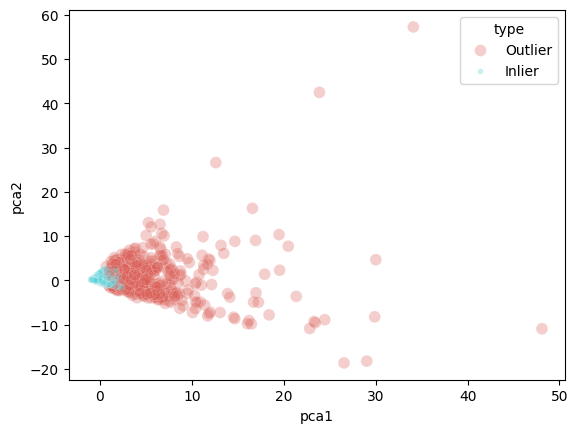

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X)

df['pca1'] = pca_result[:,0]
df['pca2'] = pca_result[:,1] 

sp = sns.scatterplot(
    data=df, 
    x="pca1", 
    y="pca2", 
    hue="type",
    hue_order = sns_order,
    legend=True,
    palette=sns.color_palette("hls", 2),
    size="type",
    size_order = sns_order,
    alpha=0.3
)

plt.show(sp)

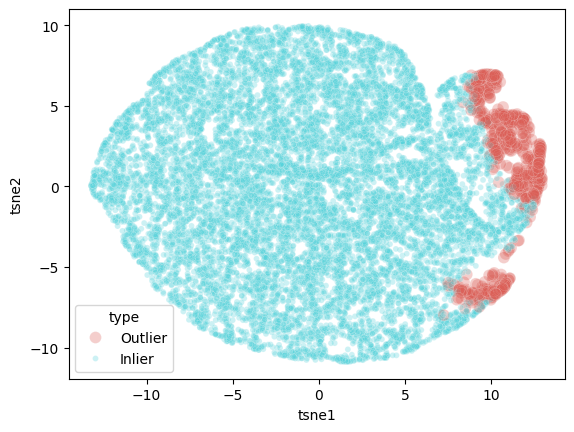

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=40, max_iter=300, random_state=42)
tsne_results = tsne.fit_transform(X)

df['tsne1'] = tsne_results[:,0]
df['tsne2'] = tsne_results[:,1] 

sp = sns.scatterplot(
    data=df, 
    x="tsne1", 
    y="tsne2", 
    hue="type",
    hue_order = sns_order,
    legend="full",
    palette=sns.color_palette("hls", 2),
    size="type",
    size_order = sns_order,
    alpha=0.3
)

plt.show(sp)

In [16]:
df_outliers = df[df["iso"] == -1]
df_outliers = df_outliers.sort_values(by='weighted_avg', ascending=False)#['products','helpful','funny', 'hours', 'recommended'], ascending=False)
df_outliers.reset_index(inplace=True)
df_outliers.index = np.arange(1, len(df_outliers)+1)
df_outliers.head()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_outliers.style.format(thousands=',', precision=2))

,user_id,helpful,funny,products,recommended,hours,sort_col,weighted_avg,iso,iso_score,type,pca1,pca2,tsne1,tsne2
1,"5,112,758","42,745","3,510","4,152","3,920","8,404.20","10,372.77","5,031.12",-1,-0.26,Outlier,48.10,-10.93,12.82,2.65
2,"5,860,500","70,096","46,186",129,107,"3,922.60","7,833.68","4,565.13",-1,-0.19,Outlier,34.10,57.26,10.40,6.82
3,"11,764,552","14,962","4,906","6,045",191,"24,249.10","24,792.87","3,371.73",-1,-0.23,Outlier,29.89,-8.24,12.82,2.40
4,"8,040,965","65,990","1,132","1,673","1,633","7,642.10","10,725.20","3,335.95",-1,-0.25,Outlier,30.02,4.67,12.03,4.08
5,"11,934,022","16,771","43,867",237,209,"34,287.90","35,412.98","3,334.16",-1,-0.23,Outlier,23.88,42.47,10.34,6.86
6,"13,933,393","13,273",814,"1,274","1,024","290,694.20","290,676.37","3,281.73",-1,-0.26,Outlier,29.03,-18.24,10.79,-6.11
7,"12,231,744","4,406","1,251","1,684",889,"264,264.60","263,842.78","3,004.91",-1,-0.25,Outlier,26.56,-18.65,10.79,-6.11
8,"1,353,327","16,203",683,"2,272","2,262","7,672.20","8,226.78","2,574.64",-1,-0.23,Outlier,24.46,-8.89,12.84,2.54
9,"1,365,585","10,381","1,301","2,470","2,081","12,640.30","12,900.85","2,478.49",-1,-0.23,Outlier,23.43,-9.58,12.85,2.51
10,"4,457,971","10,209","1,431","2,720","1,948","6,028.30","6,292.63","2,473.43",-1,-0.22,Outlier,23.30,-9.29,12.85,2.51


In [17]:
print(f'Original user count: {dfreco.user_id.nunique()}')
print(f'User candidate count: {len(df)}')
print(f'Anomaly user count: {len(df_outliers)}')

Original user count: 13781059
User candidate count: 14442
Anomaly user count: 723


In [18]:
df_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 723 entries, 1 to 723
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       723 non-null    int64  
 1   helpful       723 non-null    int64  
 2   funny         723 non-null    int64  
 3   products      723 non-null    int64  
 4   recommended   723 non-null    int64  
 5   hours         723 non-null    float64
 6   sort_col      723 non-null    float64
 7   weighted_avg  723 non-null    float64
 8   iso           723 non-null    int64  
 9   iso_score     723 non-null    float64
 10  type          723 non-null    object 
 11  pca1          723 non-null    float64
 12  pca2          723 non-null    float64
 13  tsne1         723 non-null    float32
 14  tsne2         723 non-null    float32
dtypes: float32(2), float64(6), int64(6), object(1)
memory usage: 100.9+ KB


In [19]:
df_outliers.describe()

,user_id,helpful,funny,products,recommended,hours,sort_col,weighted_avg,iso,iso_score,pca1,pca2,tsne1,tsne2
count,723.0000000,723.0000000,723.0000000,723.0000000,723.0000000,723.0000000,723.0000000,723.0000000,723.0000000,723.0000000,723.0000000,723.0000000,723.0000000,723.0000000
mean,"8,096,376.5629322","6,011.0221300","1,447.9958506",405.9930844,303.6818811,"13,256.6355463","13,268.1460773",641.1833069,-1.0000000,-0.0837819,4.6587469,0.3566011,10.9341574,1.1540408
std,"3,765,069.0687714","7,299.8601142","3,057.7217536",472.9989355,315.0657031,"17,464.8983540","17,412.0359167",477.4933045,0.0000000,0.0625132,4.4310588,4.4318264,1.2925158,4.2854409
min,"1,239.0000000",7.0000000,0.0000000,9.0000000,4.0000000,"3,412.9000000","4,198.7725451",198.0408731,-1.0000000,-0.2592832,0.4266043,-18.6476513,7.2432494,-7.9900484
25%,"5,263,997.0000000","1,501.0000000",192.0000000,142.0000000,115.0000000,"5,765.8500000","5,805.2523273",394.9999415,-1.0000000,-0.1263924,2.3227906,-1.7351359,9.9976654,-0.3210756
50%,"8,467,373.0000000","4,163.0000000",648.0000000,303.0000000,233.0000000,"8,467.9000000","8,639.0147414",498.1558219,-1.0000000,-0.0693555,3.3914712,-0.1635034,10.8250198,2.0864491
75%,"11,426,302.5000000","7,618.5000000","1,687.0000000",491.0000000,373.0000000,"15,242.2500000","15,042.1005188",707.3285982,-1.0000000,-0.0320622,5.2425041,2.2016693,12.0494776,4.2018528
max,"14,283,059.0000000","70,096.0000000","46,186.0000000","6,045.0000000","3,920.0000000","290,694.2000000","290,676.3714859","5,031.1218076",-1.0000000,-0.0000030,48.0954288,57.2594696,12.9407158,6.9788342
